In [1]:
import process as pc
import detection as dt
import dataset as ds
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import joblib
import cv2

import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [2]:
def print_image(image, keypoints : np.ndarray, scores : np.ndarray):
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if keypoints is None:
        pass
    elif keypoints.shape == (4,):
        rect = patches.Rectangle((keypoints[0], keypoints[1]), keypoints[2]-keypoints[0], keypoints[3]-keypoints[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(keypoints[0], keypoints[1], f'{scores[0]:.2f}', color='b')
    else:
        for i, kp in enumerate(keypoints):
            rect = patches.Rectangle((kp[0], kp[1]), kp[2]-kp[0], kp[3]-kp[1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(kp[0], kp[1], f'{scores[i]:.2f}', color='b')
    plt.show();

def get_reshape_params(image : np.ndarray):
    ratios = None
    if (image.shape[0] > 512 and image.shape[1] > 512):
        ratio_1 = 2 if image.shape[0] // 512 < 2 else image.shape[0] // 512
        ratio_2 = 2 if image.shape[1] // 512 < 2 else image.shape[1] // 512
        shapes = (image.shape[1] // ratio_2, image.shape[0] // ratio_1)
        params_reshape = {
            'resize': True,
            'image_size': shapes
        }
        ratios = [ratio_1, ratio_2]
        shapes, ratios
        img = cv2.resize(image, shapes)
        img.shape

    else:
        params_reshape = {
            'resize': False
        }
    return params_reshape, ratios

def adjust_boxes(boxes, ratios):
    if ratios:
        if boxes is None:
            pass
        elif boxes.shape == (4,):
            boxes = [boxes[i] * ratios[1] if i%2==0 else boxes[i] * ratios[0] for i in range(len(boxes))]
            boxes = np.array(boxes)
        else:
            box_shape = boxes.shape[0]
            for box in boxes:
                box = [int(box[i] * ratios[1]) if i%2==0 else int(box[i] * ratios[0]) for i in range(len(box))]
                boxes = np.vstack((boxes, box))
            box_shape
            boxes = np.delete(boxes, np.s_[:box_shape], axis=0)
        boxes
    return boxes


Choose an image from the list below by pressing the corresponding number or press Q to quit:
1: Velvet_Revolver.jpg
2: Giorgia.jpg
3: Basilica_Sant_Antonio.jpeg
4: Cat.jpeg
5: The_Office.jpg
6: Dua_Lipa.jpg
7: Breaking_Bad.jpg
8: Cr7.jpg
9: Fabio_Volo.jpg
10: Vittoria_Puccini.jpg
Selected image: ../data/final/Velvet_Revolver.jpg
(7008, 8100)
(10, 4)
[0.85314864 0.75544814 0.70893599 0.66862518 0.6213049 ]


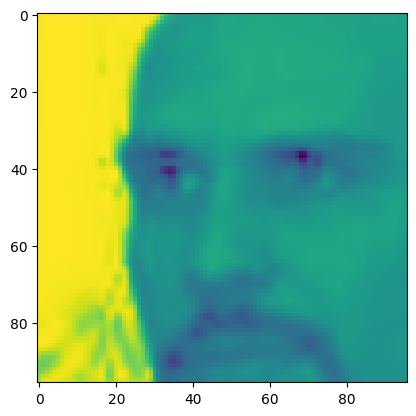

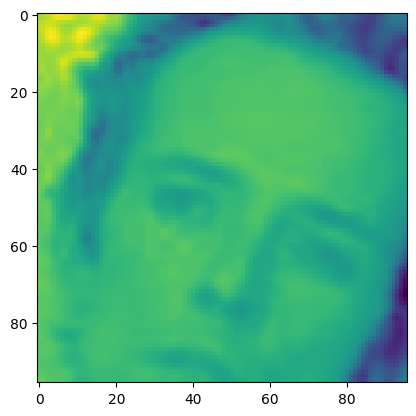

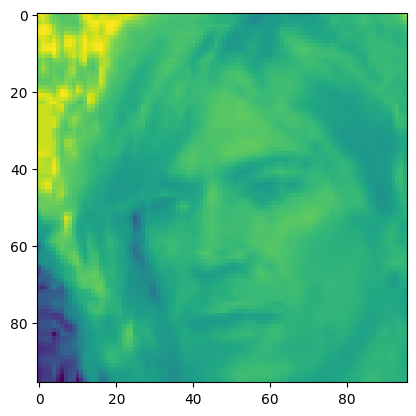

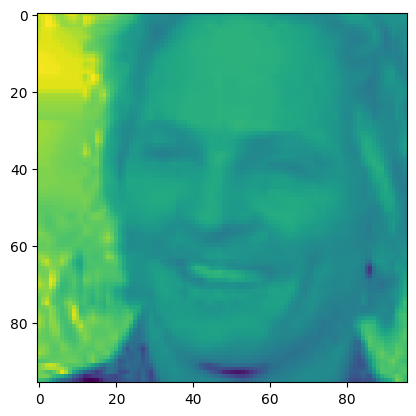

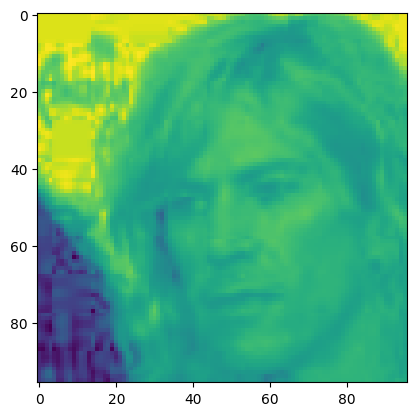

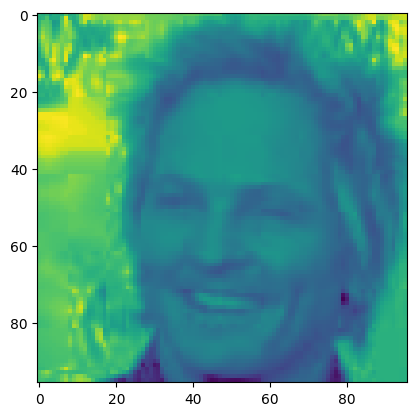

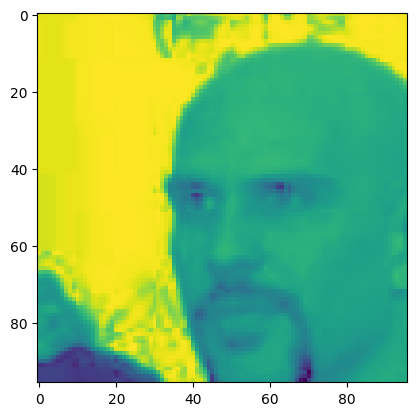

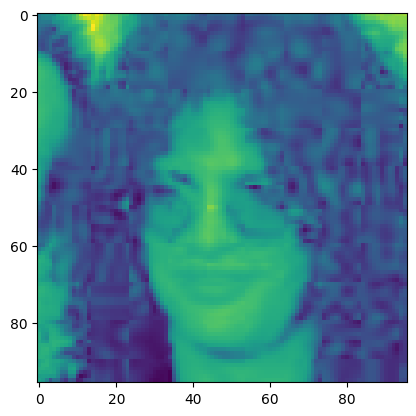

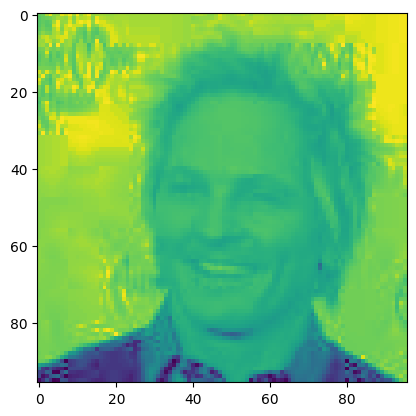

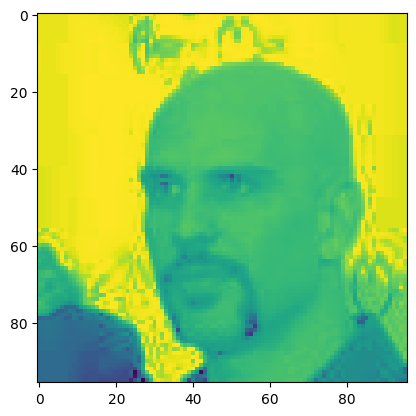

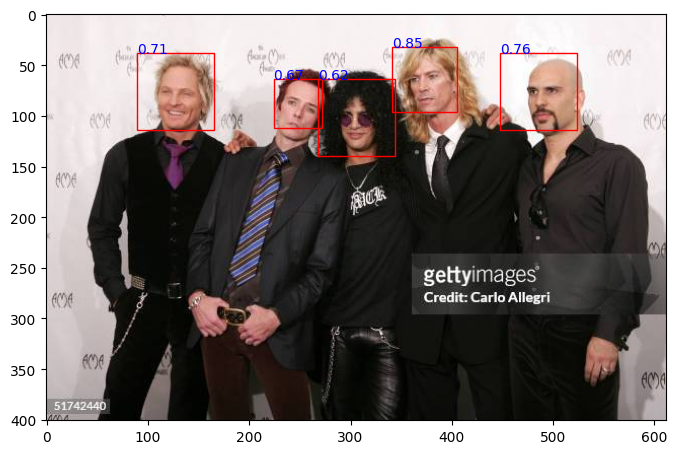

Choose an image from the list below by pressing the corresponding number or press Q to quit:
1: Velvet_Revolver.jpg
2: Giorgia.jpg
3: Basilica_Sant_Antonio.jpeg
4: Cat.jpeg
5: The_Office.jpg
6: Dua_Lipa.jpg
7: Breaking_Bad.jpg
8: Cr7.jpg
9: Fabio_Volo.jpg
10: Vittoria_Puccini.jpg


In [3]:
choice = ""
pipeline_save_path = ds.DATA_PATH+"/hog_new_dataset.pkl"
while 1:
    print("Choose an image from the list below by pressing the corresponding number or press Q to quit:", flush=True)
    for i, image in enumerate(ds.get_image_list()):
        print(f"{i+1}: {image}", flush=True)
    choice = str(input())
    if choice.upper() == "Q":
        break
    else:
        image_path = ds.get_image_path(int(choice)-1)
        print(f"Selected image: {image_path}", flush=True)

        image = cv2.imread(image_path)       
        params_reshape, ratios = get_reshape_params(image)
        pipeline = joblib.load(pipeline_save_path)
        boxes, face_kp, scores = dt.detect_faces(image, pipeline, method='HOG', threshold=0.62, overlap_threshold=0.15, window_size=(96,96), step_size=(16,16),\
                                        n_keypoints=8100, **params_reshape, verbose=False, notebook=True)

        boxes = adjust_boxes(boxes, ratios)

        for i in range(len(face_kp)):
            plt.imshow(face_kp[i][0])
            plt.show();

        image = cv2.imread(image_path)
        print_image(image, boxes, scores)
        #guardo la specifica per capire dove deve essere inserito il punteggio